In [26]:
from kan import KAN, create_dataset
import torch

# handle data
filename = "..\dataset\HistoricalData_1715050246783.csv"

# create a list to store the data
data = []
with open(filename) as f:
    # counter = 0
    for line in f.readlines()[1:]:
        data.append(float(line.split(',')[1].strip("$")))
        # counter += 1


print(data[:10])

# reverse the dataset
data = data[::-1]
# split the dataset into training and testing
train_data = data[: int(len(data) * 0.95)]
test_data = data[int(len(data) * 0.95) :]

# convert to torch tensor
train_data = torch.tensor(train_data).float()
test_data = torch.tensor(test_data).float()
print(train_data.shape, test_data.shape)

[181.71, 183.38, 173.03, 169.3, 170.33, 173.5, 169.3, 169.89, 169.02, 166.9]
torch.Size([2392]) torch.Size([126])


In [40]:
model = KAN(width=[1,10,5,1], grid=5, k=3, seed=0)

train_input = torch.range(0, len(train_data) - 1).unsqueeze(1)
train_label = train_data.unsqueeze(1)
test_input = torch.range(0, len(test_data) - 1).unsqueeze(1)
test_label = test_data.unsqueeze(1)

dataset = {
    "train_input": train_input,
    "train_label": train_label,
    "test_input": test_input,
    "test_label": test_label
}

# train the model
model.train(dataset, opt="LBFGS", steps=20, lamb=0.001, lamb_entropy=2.);

C:\Users\v2-Za\AppData\Local\Temp\ipykernel_1844\3223745386.py:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  train_input = torch.range(0, len(train_data) - 1).unsqueeze(1)
C:\Users\v2-Za\AppData\Local\Temp\ipykernel_1844\3223745386.py:5: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  test_input = torch.range(0, len(test_data) - 1).unsqueeze(1)
description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

train loss: 1.03e+01 | test loss: 1.59e+02 | reg: 2.91e+01 : 100%|██| 20/20 [01:27<00:00,  4.38s/it]


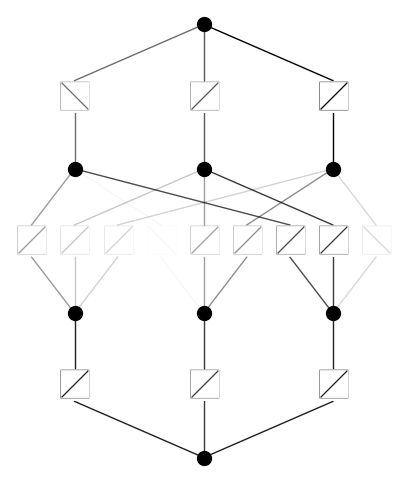

In [41]:
model = model.prune()
model(dataset['train_input'])
model.plot(beta=3)

In [3]:
# it seems that removing edge manually does not change results too much. We include both for completeness.
remove_edge = True

if remove_edge == True:
    model.remove_edge(0,0,1)
    model.remove_edge(0,1,1)
    model.remove_edge(0,2,0)
    model.remove_edge(0,3,0)
else:
    pass

In [4]:
grids = [3,5,10,20,50]
#grids = [5]

train_rmse = []
test_rmse = []

for i in range(len(grids)):
    model = KAN(width=[4,2,1,1], grid=grids[i], k=3, seed=0).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=50, stop_grid_update_step=30);
    train_rmse.append(results['train_loss'][-1].item())
    test_rmse.append(results['test_loss'][-1].item())

train loss: 4.68e-03 | test loss: 4.65e-03 | reg: 7.18e+00 : 100%|██| 50/50 [00:34<00:00,  1.43it/s]
train loss: 1.85e-03 | test loss: 1.88e-03 | reg: 7.27e+00 : 100%|██| 50/50 [00:32<00:00,  1.54it/s]
train loss: 1.67e-04 | test loss: 1.58e-04 | reg: 7.15e+00 : 100%|██| 50/50 [00:39<00:00,  1.27it/s]
train loss: 1.49e-05 | test loss: 1.33e-05 | reg: 7.15e+00 : 100%|██| 50/50 [00:49<00:00,  1.01it/s]
train loss: 7.81e-07 | test loss: 1.24e-06 | reg: 7.15e+00 : 100%|██| 50/50 [01:34<00:00,  1.89s/it]


[0.004676620056267991, 0.0018545762361784552, 0.00016712565490647625, 1.4944049254287644e-05, 7.806967964665928e-07]
[0.004653487688711824, 0.0018804239846781038, 0.00015800498480465517, 1.3296794382010341e-05, 1.2418843339589226e-06]


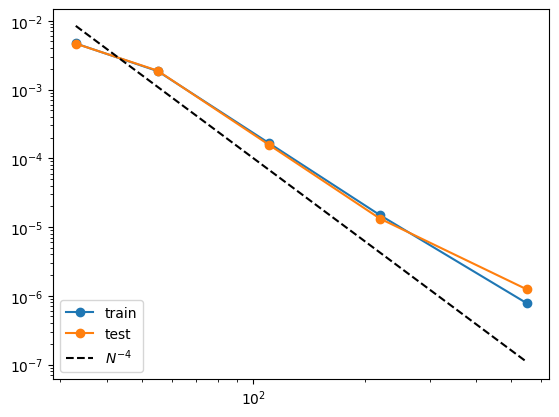

In [5]:
import numpy as np
import matplotlib.pyplot as plt

n_params = np.array(grids) * (4*2+2*1+1*1)
plt.plot(n_params, train_rmse, marker="o")
plt.plot(n_params, test_rmse, marker="o")
plt.plot(n_params, 10000*n_params**(-4.), color="black", ls="--")
plt.legend(['train', 'test', r'$N^{-4}$'], loc="lower left")
plt.xscale('log')
plt.yscale('log')
print(train_rmse)
print(test_rmse)

### Two-layer KAN

Now we show that a 2 two-layer KAN performs much worse for this task

In [6]:
from kan import KAN, create_dataset
import torch

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[4,9,1], grid=3, k=3, seed=0)
f = lambda x: torch.exp((torch.sin(torch.pi*(x[:,[0]]**2+x[:,[1]]**2))+torch.sin(torch.pi*(x[:,[2]]**2+x[:,[3]]**2)))/2)
dataset = create_dataset(f, n_var=4, train_num=3000)

# train the model
model.train(dataset, opt="LBFGS", steps=20, lamb=0.001, lamb_entropy=2.);

train loss: 7.42e-02 | test loss: 7.32e-02 | reg: 1.35e+01 : 100%|██| 20/20 [00:30<00:00,  1.52s/it]


In [7]:
grids = [3,5,10,20,50]
#grids = [5]

train_rmse = []
test_rmse = []

for i in range(len(grids)):
    model = KAN(width=[4,9,1], grid=grids[i], k=3, seed=0).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=50, stop_grid_update_step=30);
    train_rmse.append(results['train_loss'][-1].item())
    test_rmse.append(results['test_loss'][-1].item())

train loss: 3.74e-02 | test loss: 4.48e-02 | reg: 1.79e+01 : 100%|██| 50/50 [01:11<00:00,  1.43s/it]
train loss: 1.29e-02 | test loss: 1.53e-02 | reg: 1.78e+01 : 100%|██| 50/50 [01:14<00:00,  1.49s/it]
train loss: 4.26e-03 | test loss: 6.16e-03 | reg: 1.77e+01 : 100%|██| 50/50 [01:46<00:00,  2.13s/it]
train loss: 3.25e-03 | test loss: 2.59e-02 | reg: 1.75e+01 : 100%|██| 50/50 [02:22<00:00,  2.85s/it]
train loss: 3.60e-02 | test loss: 1.89e+01 | reg: 1.66e+01 : 100%|██| 50/50 [05:12<00:00,  6.25s/it]


[0.03740749813229355, 0.0129072819904752, 0.004259625399941143, 0.003246632834750432, 0.03597184670501935]
[0.0448023326797386, 0.015317469389740851, 0.00616367307467508, 0.02587553713706475, 18.933465793670795]


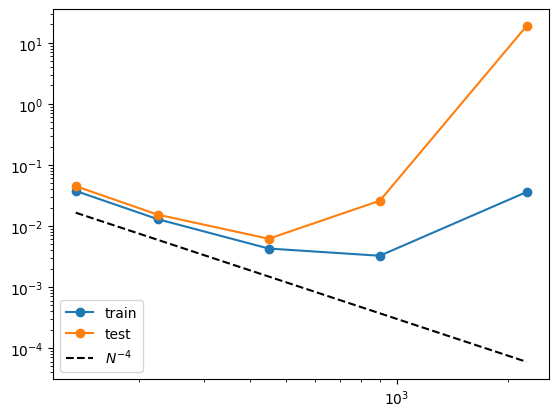

In [8]:
import numpy as np
import matplotlib.pyplot as plt

n_params = np.array(grids) * (4*9+9*1)
plt.plot(n_params, train_rmse, marker="o")
plt.plot(n_params, test_rmse, marker="o")
plt.plot(n_params, 300*n_params**(-2.), color="black", ls="--")
plt.legend(['train', 'test', r'$N^{-4}$'], loc="lower left")
plt.xscale('log')
plt.yscale('log')
print(train_rmse)
print(test_rmse)